# Implementation Testing File 

Author: Tuan Khoi Nguyen - 24/1/2021

**This file is run on a single file to check its validity first, then the whole function will be applied in the full script for all files.**

*One reason you might like to do that is to calculate the change in energies in the flow field.  At any instant, how much potential or kinetic energy is in the gravity current. *

*Following on from my email to you, if you look at the attached paper, the equations for kinetic and potential energies are given in Eqs. (17) and (18) respectively (note that theta=0 for the simulation data I am giving you).  So do you think you can calculate the integratl given the pymech library to read the data from the field files?  Using the pymech library, you should have the velocity (u and v) and also the coordinates of the data points.*

(17): K_H = int(0.5 * rho * (u^2+v^2+w^2)dV) 


In [209]:
import pymech.neksuite as nek
import numpy as np
import pandas as pd 
import scipy.spatial


## Let's start with 2D data example: an element in SCG0.f00001

In [210]:
data2d = nek.readnek("..\..\\8-12-20\SGC0.f00001")
print(data2d.nel)
example = data2d.elem[0] # We will work on this

2048


In [211]:
npoints = example.temp.size # Number of points in total

# Array is always 4D by default, even if data is 2D
print(example.pos.shape)

# Reshape the array to become . Now pos has type [[X1,X2,...],[Y1,Y2,...],[Z1,Z2,...]]
pos_rearranged = np.reshape(example.pos, (3,npoints))
print(pos_rearranged.shape)

# Get the transpose to make it [[X1,Y1,Z1],...]
# Also opt out Z-column since data is 2D and all z-values will be 0
pos2d = pos_rearranged.T[:,:2]
pos2d.shape

(3, 1, 12, 12)
(3, 144)


(144, 2)

In [212]:
# Do the same thing for Velocity
vel_rearranged = np.reshape(example.vel, (3,npoints))
vel2d = vel_rearranged.T[:,:2]
print(vel2d.shape)

# Get the sum of velocity squares for each row (u^2+v^2)
ssq = np.sum(vel2d**2, axis=1)
ssq.shape

(144, 2)


(144,)

In [213]:
# Calculate V

# Reshape temp (rho) as well
temp2d = np.reshape(example.temp, (npoints))

# Get V using the formula:
v2d = 0.5*np.multiply(temp2d, ssq)
v2d.shape

(144,)

In [214]:
## Combining to make a 3d array of x,y,V

# New data should now be an array of [X,Y,V]
pts2d = np.concatenate((pos2d,np.reshape(v2d,(npoints,1))), axis=1)
pts2d.shape

(144, 3)

## Trapezodial method using Delaunay Triangulation

This section will go through how the intergal is calculated using the method

Based on an answer from [this thread](https://stackoverflow.com/questions/8792551/volume-under-plane-defined-by-data-points-python) 

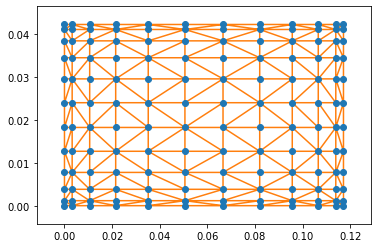

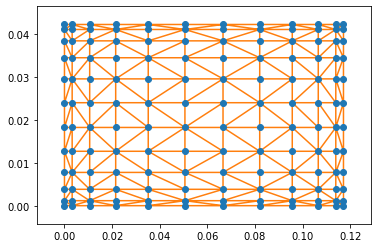

In [215]:
# This built-in Delaunay function will create triangles between the points
d1 = scipy.spatial.Delaunay(pts2d[:,:2])

# Plotting, so that you know what I mean. I don't know why it returned 2 plots tho
scipy.spatial.delaunay_plot_2d(d1)


In [216]:
# This will return an array of triangles
# Each triagle is an array of 3 points
# Each point is an array of 3 coordinates
tri = pts2d[d1.vertices]
tri.shape

(242, 3, 3)

The integral under each triangle can be approximated by a block with top and bottom surfaces being the triangle itself, with the height being the average of the 3 points' magnitude in the 3rd direction (in this case, V)

In [217]:
# Getting 2 vectors of each triangle 
a = tri[:,0,:2] - tri[:,1,:2]
b = tri[:,0,:2] - tri[:,2,:2]

# Using Area = 0.5 |A x B|, we'll get the area for each triangle
area2d = 0.5*np.cross(a, b)
area2d.shape

(242,)

In [218]:
# Get the average V-value of each triangle
avg2d = tri[:,:,2].mean(axis=1)
avg2d.shape

(242,)

In [228]:
# Get the volume under each triangle
vol2d = np.multiply(np.abs(area2d),avg2d)
print(vol2d.shape)

# And sum all up to get the final result of integral for the element
int_res = vol2d.sum()
int_res

(242,)


3.6413678174273834e-08

The steps can then be repeated for all elements, and add up to get the full integral result.

## Let's try this on a 3D element

In [220]:
data = nek.readnek("..\Mesh01_3D0.f00001")
example = data.elem[0] # We will work on this
data.nel

22410

In [221]:
npoints = example.temp.size # Number of points in total

# Array is always 4D by default, even if data is 2D
print(example.pos.shape)

# Reshape the array to become 2D. Now pos has type [[X1,X2,...],[Y1,Y2,...],[Z1,Z2,...]]
pos_rearranged = np.reshape(example.pos, (3,npoints))
print(pos_rearranged.shape)

# Get the transpose to make it [[X1,Y1,Z1],...]
pos = pos_rearranged.T
pos.shape

(3, 6, 6, 6)
(3, 216)


(216, 3)

In [222]:
# Do the same thing for Velocity
vel_rearranged = np.reshape(example.vel, (3,npoints))
vel = vel_rearranged.T
print(vel.shape)

# Get the sum of velocity squares for each row (u^2+v^2+w^2)
ssq = np.sum(vel**2, axis=1)
ssq.shape

(216, 3)


(216,)

In [223]:
# Calculate V

# Reshape temp (rho) as well
temp = np.reshape(example.temp, (npoints))

# Get V using the formula:
v = 0.5*np.multiply(temp, ssq)
v.shape

(216,)

In [224]:
## Combining to make a 3d array of x,y,V

# New data should now be an array of [X,Y,V]
pts = np.concatenate((pos,np.reshape(v,(npoints,1))), axis=1)
pts.shape

(216, 4)

### Using Delaunay for 3D, the subset of points will become tetrahedrons rather than triangles

In [225]:
d=scipy.spatial.Delaunay(pts[:,:3])
## Unfortunately scipy's plot function can only plot for 2D, but you know how it works already so should be all good
t = pts[d.vertices]
t.shape

(925, 4, 4)

In [229]:
# Vectors of tetrahedron that originated from the 1st point
v1 = t[:,0,:3] - t[:,1,:3]
v2 = t[:,0,:3] - t[:,2,:3]
v3 = t[:,0,:3] - t[:,3,:3]

# The formula to get a tetrahedron's volume with vertices A,B,C from the same point is |{A x B).C| / 6

# V1 x V2
surf = np.cross(v1,v2)

# |(V1 x V2).V3| / 6
# The list comprehension will help return an array of corresponding volume for the tetrahedrons
vol = np.array([np.dot(v3[i],surf[i]) for i in range(0,len(v3))]) / 6.0 

# Once again, take the average temp for each tetrahedron
avg = t[:,:,3].mean(axis = 1)

# By geometry approximation, the 4D volume will be retrieved using |V| x Temp
vol4d = np.multiply(np.abs(vol),avg)
vol4d.shape

(925,)

In [230]:
# And the integral is now retrieved by summing up again
vol4d.sum()

6.6955817219395875e-09